In [1]:
import pickle
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
from concurrent.futures import ProcessPoolExecutor
from sklearn.utils import shuffle
import random
import re

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikegen

import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import torch.nn as nn
import torch.nn.functional as F

# import audio_import_giantstep as aig
import audio_import_ballroom as aib
import audio_import_syn as ais
import time
import beepy
import tonic


Number of cores used: 15
Number of cores used: 15


Loading and preprocessing training data...


  0%|          | 0/2 [00:00<?, ?it/s]






100%|██████████| 2/2 [06:58<00:00, 209.45s/it]



Done with preprocessing!
preparing data loaders with batch size 64
length of training data: 13209


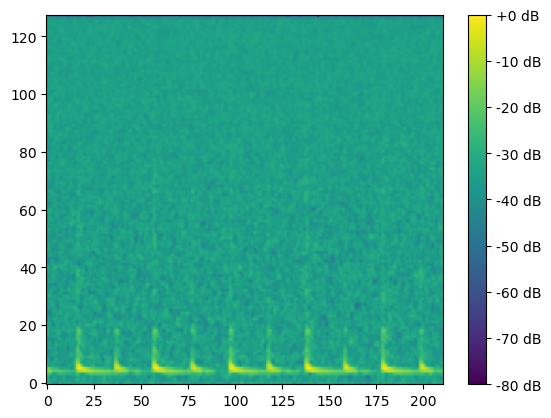

sum of dataset: 26467
groundtruth:  104
bpm_librosa:  105.46875
input shape ball: (128, 211)


In [2]:
batch_size = 64
files_to_load = 2000
SR =  18000 #16000 # int(22050/2)


train_set_syn, val_set_syn, input_shape_syn = ais.import_audio_get_loader(batch_size=batch_size, 
                                                             only_dataset=True, 
                                                             train_data_ratio=0.8, 
                                                             files_to_load=files_to_load,
                                                             sr=SR,
                                                             )

# train_set_giant, val_set_giant, input_shape_giant = aig.import_audio_get_loader(batch_size=batch_size, 
#                                                              only_dataset=True, 
#                                                              train_data_ratio=0.8, 
#                                                              files_to_load=150,
#                                                              sr=SR,
#                                                              )



# train_set_ball, val_set_ball, input_shape_ball = aib.import_audio_get_loader(batch_size=batch_size, 
#                                                              only_dataset=True, 
#                                                              train_data_ratio=0.9, 
#                                                              files_to_load=1000,
#                                                              sr=SR,
#                                                              augmented=True,
#                                                              )

# for i in range(0,3):
#     train_set_ball_2, val_set_ball_2, input_shape_ball_2 = aib.import_audio_get_loader(batch_size=batch_size, 
#                                                              only_dataset=True, 
#                                                              train_data_ratio=0.9, 
#                                                              files_to_load=1000,
#                                                              sr=SR,
#                                                              augmented=True,
#                                                              )
#     train_set_ball = ConcatDataset([train_set_ball, train_set_ball_2])
#     val_set_ball = ConcatDataset([val_set_ball, val_set_ball_2])

# # train_set_ball_2, val_set_ball_2, input_shape_ball_2 = aib.import_audio_get_loader(batch_size=batch_size, 
# #                                                              only_dataset=True, 
# #                                                              train_data_ratio=0.9, 
# #                                                              files_to_load=1000,
# #                                                              sr=SR,
# #                                                              augmented=False,
# #                                                              )

train_loader = DataLoader(train_set_syn, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set_syn, batch_size=batch_size, shuffle=True)



# train_loader = DataLoader(train_set_giant+train_set_ball+train_set_syn, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_set_giant+val_set_ball+val_set_syn, batch_size=batch_size, shuffle=True)


example_batch = next(iter(train_loader))
mel, groundtruth, librosa_bpm = example_batch

single_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension

# librosa.display.specshow(librosa.power_to_db(data, ref=np.max), y_axis='mel', x_axis='time')
plt.imshow(librosa.power_to_db(single_mel, ref=np.max), origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.show()



print(f"sum of dataset: {len(train_loader.dataset) +len(val_loader.dataset)}")
print("groundtruth: ", groundtruth[0].cpu().numpy())
print("bpm_librosa: ", librosa_bpm[0].cpu().numpy())
print(f"input shape ball: {input_shape_syn}")
# print(f"input shape giant: {input_shape_giant}")
# print(f"input shape syn: {input_shape_syn}")


input_shape = input_shape_syn



In [3]:
# pickle datasets

def save_preprocessed_data(loader: DataLoader, filename):
    with open(filename, 'wb') as f:
        pickle.dump(loader.dataset, f)
        
# Assuming `data, labels, val_bpm` are your preprocessed data
sum_loader = DataLoader(ConcatDataset([train_set_syn, val_set_syn]), batch_size=batch_size, shuffle=True)
save_preprocessed_data(sum_loader, 'preprocessed_data_synthetic_multi_instrument.pkl')

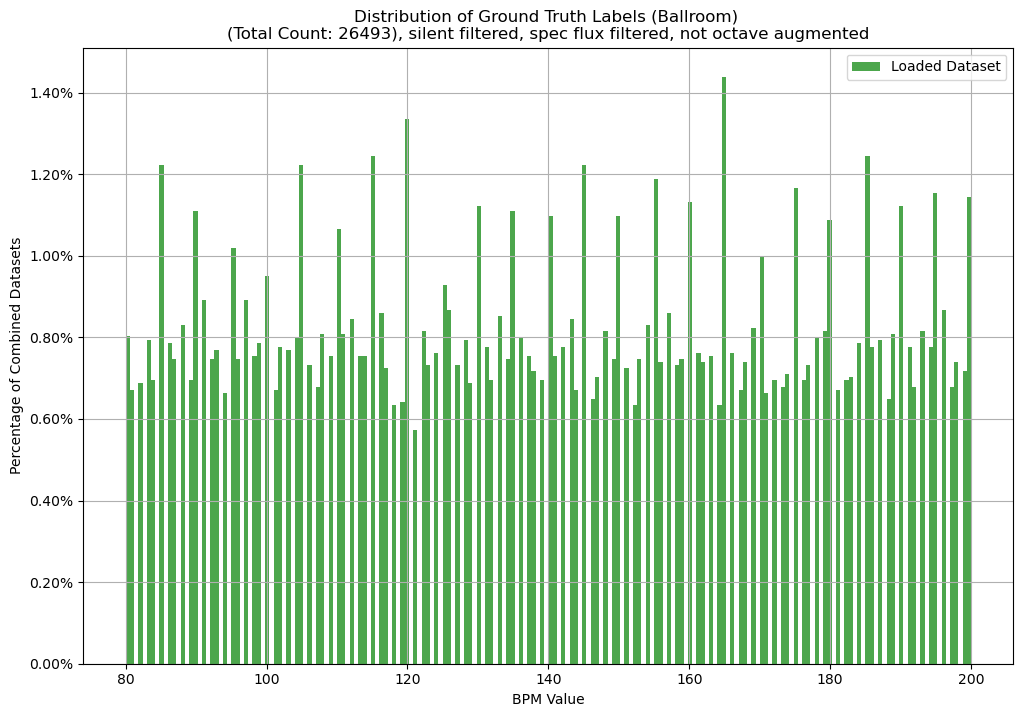

max ground truth: 200
min ground truth: 80


In [2]:
# Loading the datasets from disk

def load_preprocessed_data(filename):
    with open(filename, 'rb') as f:
        train_dataset = pickle.load(f)
    return train_dataset

from torch.utils.data import random_split

#loaded_dataset = load_preprocessed_data('preprocessed_data_ball_augmented.pkl')
loaded_dataset = load_preprocessed_data('preprocessed_data_synthetic.pkl')
ground_truth_max = 200
ground_truth_min = 80
num_classes = ground_truth_max - ground_truth_min + 1

filtered_dataset = [item for item in loaded_dataset if ground_truth_min <= item[1] <= ground_truth_max]
# filtered_dataset = loaded_dataset
#filtered_dataset = filtered_dataset[:int(len(filtered_dataset)/4)]
train_data_ratio = 0.8
train_len = int(train_data_ratio * len(filtered_dataset))  # 80% for training
val_len = len(filtered_dataset) - train_len  # 20% for validation

train_dataset, val_dataset = random_split(filtered_dataset, [train_len, val_len])

batch_size_new = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_new, shuffle=True)
input_shape = train_dataset[0][0].squeeze(0).shape


ground_truths = [item[1] for item in filtered_dataset]

# Convert the list of ground truths to a numpy array for easy min/max computation
ground_truths_array = np.array(ground_truths)


total_samples = len(ground_truths_array)

weights = np.ones_like(ground_truths_array) / total_samples


plt.figure(figsize=(12, 8))

# Plotting the histograms stacked
plt.hist([ground_truths_array], bins=200, color=['green'], 
         alpha=0.7, label=['Loaded Dataset'], weights=[weights], stacked=True)

plt.xlabel('BPM Value')
plt.ylabel('Percentage of Combined Datasets')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
plt.title(f'Distribution of Ground Truth Labels (Ballroom) \n(Total Count: {total_samples}), silent filtered, spec flux filtered, not octave augmented')
plt.legend()
plt.grid(True)
plt.show()
print(f"max ground truth: {np.max(ground_truths_array)}")
print(f"min ground truth: {np.min(ground_truths_array)}")


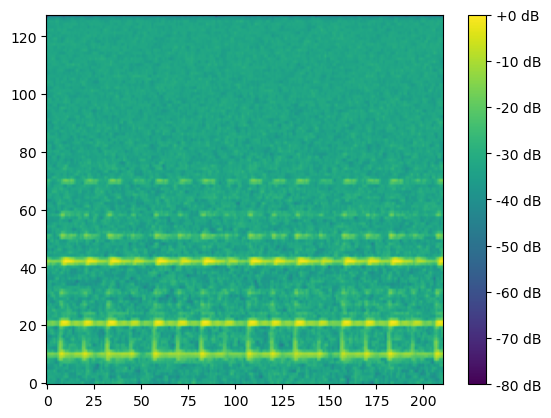

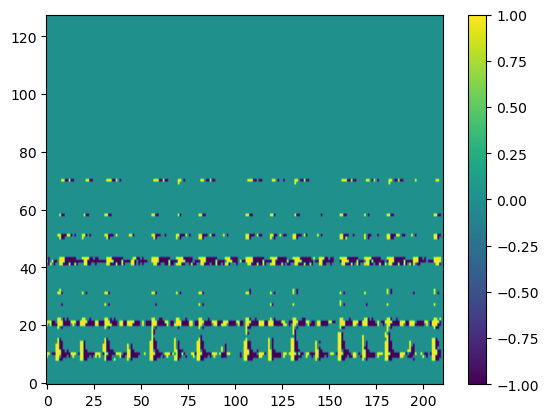

In [2]:
# Loading the datasets from disk

def load_preprocessed_data(filename):
    with open(filename, 'rb') as f:
        train_dataset = pickle.load(f)
    return train_dataset

from torch.utils.data import random_split

#loaded_dataset = load_preprocessed_data('preprocessed_data_ball_augmented.pkl')
#loaded_dataset = load_preprocessed_data('preprocessed_data_synthetic.pkl')
loaded_dataset = load_preprocessed_data('preprocessed_data_synthetic_multi_instrument.pkl')
ground_truth_max = 200
ground_truth_min = 80
num_classes = ground_truth_max - ground_truth_min + 1

filtered_dataset = [item for item in loaded_dataset if ground_truth_min <= item[1] <= ground_truth_max]
# filtered_dataset = loaded_dataset
filtered_dataset = filtered_dataset[:int(len(filtered_dataset)/2)]
train_data_ratio = 0.8
train_len = int(train_data_ratio * len(filtered_dataset))  # 80% for training
val_len = len(filtered_dataset) - train_len  # 20% for validation

train_dataset, val_dataset = random_split(filtered_dataset, [train_len, val_len])

batch_size_new = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_new, shuffle=True)
input_shape = train_dataset[0][0].squeeze(0).shape


example_batch = next(iter(train_loader))
mel, groundtruth, librosa_bpm = example_batch

single_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension
single_mel_db = librosa.power_to_db(single_mel, ref=np.max)
# min max normalize single_mel_db

# librosa.display.specshow(librosa.power_to_db(data, ref=np.max), y_axis='mel', x_axis='time')
plt.imshow(librosa.power_to_db(single_mel, ref=np.max), origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.show()


# Define a threshold for change detection
threshold = 0.0032  # This value may need tuning

# Find the changes from one frame to the next
diffs = np.diff(single_mel, axis=1)

# Get event coordinates where change exceeds threshold
event_coords = np.argwhere(np.abs(diffs) >= threshold)

# Build events with [x, y, time, polarity] structure
events = []
for coord in event_coords:
    y, x = coord  # flip coordinates to match your description
    polarity = 1 if diffs[coord[0], coord[1]] > 0 else -1
    events.append([x, y, x, polarity])  # Using x as a simple stand-in for time

events = np.array(events)

# If you wish to visualize the events somehow:
# This is a simplification; you'd likely want a better visualization
event_img = np.zeros_like(single_mel)
for event in events:
    event_img[event[1], event[0]] = event[3]  # Polarities as pixel values

plt.imshow(event_img, origin='lower', aspect='auto')
plt.colorbar()
plt.show()


# Assume `mel` is your list of Mel spectrograms and `groundtruth` is your list of ground truth labels
assert len(mel) == len(groundtruth), "The lists must be of the same length"

# Pair each Mel spectrogram with its corresponding ground truth label
paired_data = list(zip(mel, groundtruth))

# Sort the paired data based on the ground truth labels
sorted_data = sorted(paired_data, key=lambda x: x[1])

# Separate the sorted pairs back into two lists
sorted_mel, sorted_groundtruth = zip(*sorted_data)

# Now you can use `sorted_mel` and `sorted_groundtruth` in place of `mel` and `groundtruth` in your code

torch.Size([2, 100, 211])


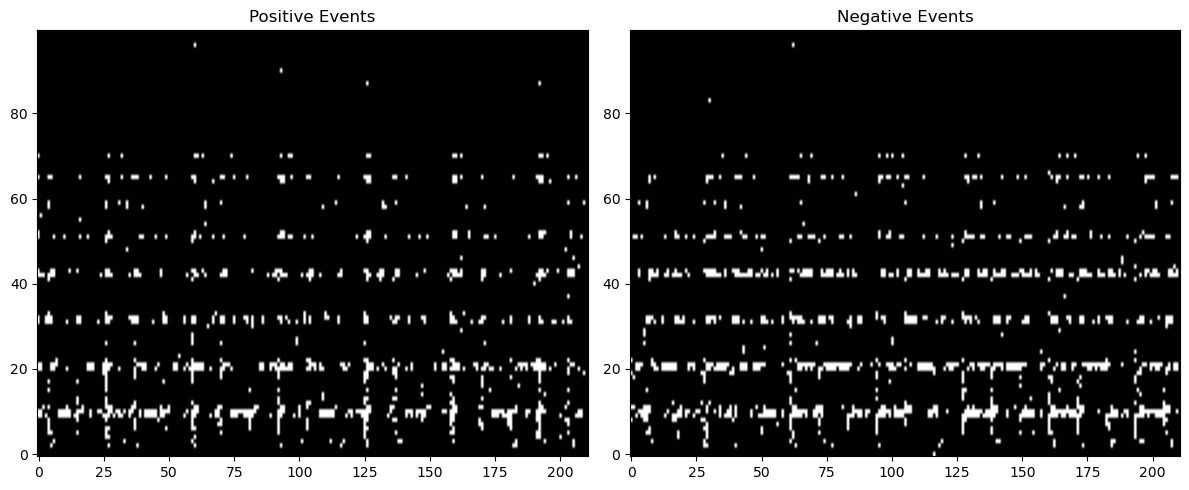

In [3]:
def transform_mel(single_mel, threshold=0.0032):
    frequency_cutoff = 100
    single_mel = single_mel[:frequency_cutoff]    
    diffs = np.diff(single_mel, axis=1)
    event_coords = np.argwhere(np.abs(diffs) >= threshold)

    positive_event_img = np.zeros_like(single_mel)
    negative_event_img = np.zeros_like(single_mel)

    for coord in event_coords:
        y, x = coord
        polarity = 1 if diffs[coord[0], coord[1]] > 0 else -1
        if polarity == 1:
            positive_event_img[y, x] = 1
        else:
            negative_event_img[y, x] = 1

    return positive_event_img, negative_event_img

class TransformedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        mel, groundtruth, bpm_librosa = self.dataset[idx]
        positive, negative = transform_mel(mel.squeeze(0))
        transformed_mel = np.stack([positive, negative], axis=0)
        
        sample = torch.tensor(transformed_mel).to(torch.float32)
        groundtruth = groundtruth.clone().detach().to(torch.long)
        bpm_librosa = bpm_librosa.clone().detach().to(torch.float32)
        
        return sample, groundtruth, bpm_librosa

    
    # Apply the transformation
transformed_train_dataset = TransformedDataset(train_dataset)
transformed_val_dataset = TransformedDataset(val_dataset)

# Create DataLoaders
batch_size_new = 64
train_loader = DataLoader(transformed_train_dataset, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(transformed_val_dataset, batch_size=batch_size_new, shuffle=True)

mel, gt, lib = next(iter(train_loader))

example_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension
print(example_mel.shape)

input_shape = example_mel.shape

import matplotlib.pyplot as plt

def plot_mel_channels(mel_tensor):
    # Ensure the tensor is on the CPU for visualization
    mel_tensor = mel_tensor.cpu()
    
    # Extract positive and negative events
    positive_events = mel_tensor[0]
    negative_events = mel_tensor[1]

    fig, axarr = plt.subplots(1, 2, figsize=(12, 5))
    
    axarr[0].imshow(positive_events, origin='lower', aspect='auto', cmap='gray')
    axarr[0].set_title('Positive Events')
    
    axarr[1].imshow(negative_events, origin='lower', aspect='auto', cmap='gray')
    axarr[1].set_title('Negative Events')
    
    plt.tight_layout()
    plt.show()

# Visualization example:
plot_mel_channels(mel[0])  # visualize the first sample from the batch


In [7]:
# Pair each Mel spectrogram with its corresponding ground truth label
paired_data = list(zip(mel, groundtruth))

# Sort the paired data based on the ground truth labels
sorted_data = sorted(paired_data, key=lambda x: x[1])

# Separate the sorted pairs back into two lists
sorted_mel, sorted_groundtruth = zip(*sorted_data)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive
import librosa
from torch.utils.data import DataLoader
import pickle
import cv2  # Importing OpenCV for the additional processing steps

def plot_events(mel_idx, threshold):
    frequency_cutoff = 100
    single_mel = sorted_mel[mel_idx].squeeze(0)
    single_mel = single_mel[:frequency_cutoff]
    single_groundtruth = sorted_groundtruth[mel_idx]
    
    single_mel_db = single_mel[:frequency_cutoff]
    single_mel_db = np.asarray(single_mel_db)


        # Define a threshold for change detection
    # Find the changes from one frame to the next
    diffs = np.diff(single_mel, axis=1)

    # Get event coordinates where change exceeds threshold
    event_coords = np.argwhere(np.abs(diffs) >= threshold)

    # Build events with [x, y, time, polarity] structure
    events = []
    for coord in event_coords:
        y, x = coord  # flip coordinates to match your description
        polarity = 1 if diffs[coord[0], coord[1]] > 0 else -1
        events.append([x, y, x, polarity])  # Using x as a simple stand-in for time

    events = np.array(events)

    # If you wish to visualize the events somehow:
    # This is a simplification; you'd likely want a better visualization
    event_img = np.zeros_like(single_mel)
    for event in events:
        event_img[event[1], event[0]] = event[3]  # Polarities as pixel values
        
        
     #######################   
        
    baseline = cv2.blur(single_mel_db, (3, 3))  # local baseline
    refined_diffs = single_mel_db - baseline  # refined temporal contrast
    
    #refined event coords
    event_coords_refined = np.argwhere(np.abs(refined_diffs) >= threshold)
    events_refined = []
    for coord in event_coords_refined:
        y, x = coord  # flip coordinates to match your description
        polarity = 1 if refined_diffs[coord[0], coord[1]] > 0 else -1
        events_refined.append([x, y, x, polarity])  # Using x as a simple stand-in for time
    
    events_refined = np.array(events_refined)
    event_img_refined = np.zeros_like(single_mel)
    for event in events_refined:
        event_img_refined[event[1], event[0]] = event[3]
        

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 10))
    
    # Plot Mel spectrogram
    axs[0].imshow(single_mel_db, origin='lower', aspect='auto', cmap='viridis')
    axs[0].set_title(f'Mel Spectrogram - Ground Truth: {single_groundtruth}')
    
    # Plot event-based representation
    im = axs[1].imshow(event_img, origin='lower', aspect='auto')
    axs[1].set_title('Event-based representation')
    #fig.colorbar(im, ax=axs[1])
    
    im = axs[2].imshow(event_img_refined, origin='lower', aspect='auto')
    axs[2].set_title('Event-based representation refined')

    plt.tight_layout()
    plt.show()


from ipywidgets import Layout
slider_layout = Layout(width='80%')  # Adjust as needed

    
# Create sliders for various parameters
idx_slider = widgets.IntSlider(value=1, min=0, max=len(sorted_mel)-1, step=1, description='idx:', continuous_update=True, layout=slider_layout)
threshold_slider = widgets.FloatSlider(value=0.0032, min=0.0, max=0.22, step=0.0001, description='threshold:', continuous_update=True, layout=slider_layout, readout_format='.4f')

# Create interactive plot
interactive_plot = interactive(
    plot_events,
    mel_idx=idx_slider,
    threshold=threshold_slider,

)

interactive_plot.layout.width = '100%'
output = interactive_plot.children[-1]
output.layout.height = '80%'
output.layout.width = '80%'
interactive_plot

interactive(children=(IntSlider(value=1, description='idx:', layout=Layout(width='80%'), max=63), FloatSlider(…

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive
import librosa
from torch.utils.data import DataLoader
import pickle
import cv2  # Importing OpenCV for the additional processing steps

def plot_events(mel_idx, segment_cnt, sobel_ksize, adaptive_block_size, adaptive_c, otsu_thresh):
    single_mel = mel[mel_idx].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension
    single_groundtruth = groundtruth[mel_idx]
    single_mel_db = librosa.power_to_db(single_mel, ref=np.max)
    # Improved Difference Calculation
    grad_x = cv2.Sobel(single_mel_db, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
    grad_y = cv2.Sobel(single_mel_db, cv2.CV_64F, 0, 1, ksize=sobel_ksize)
    diffs = np.hypot(grad_x, grad_y)  # Magnitude of gradients
    
    # Adaptive Thresholding
    thresholded = cv2.adaptiveThreshold(
        diffs.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, adaptive_block_size, adaptive_c
    )
    
    # Applying a morphological operation to reduce noise and emphasize features
    kernel = np.ones((3,3), np.uint8)
    thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)
    
    # Binarization and Temporal Segmentation
    _, binarized = cv2.threshold(diffs.astype(np.uint8), otsu_thresh, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    segments = np.array_split(binarized, segment_cnt, axis=1)  # Split into 10 segments along time axis
    
    # Further processing per segment could be applied here...
    
    # Visualization of one segment as example
    segment_img = segments[0]
    event_coords = np.argwhere(segment_img > 0)
    events = []
    for coord in event_coords:
        y, x = coord
        polarity = 1 if diffs[y, x] > 0 else -1  # Using sign of diffs as the polarity
        events.append([x, y, x, polarity])  # Using x as a simple stand-in for time
    
    events = np.array(events)
    event_img = np.zeros_like(segment_img)
    for event in events:
        event_img[event[1], event[0]] = event[3]  # Polarities as pixel values

    plt.figure(figsize=(5, 5))
    plt.title(f"Groundtruth: {single_groundtruth}")
    plt.imshow(event_img, origin='lower', aspect='auto')
    plt.colorbar()
    plt.show()
    
    
# Create sliders for various parameters
idx_slider = widgets.IntSlider(value=10, min=1, max=batch_size_new-1, step=1, description='idx:', continuous_update=True)
threshold_slider = widgets.IntSlider(value=10, min=1, max=100, step=1, description='segments:', continuous_update=True)
sobel_ksize_slider = widgets.IntSlider(value=3, min=1, max=7, step=2, description='Sobel Kernel Size:', continuous_update=True)  # Sobel kernel size (odd numbers only)
adaptive_block_size_slider = widgets.IntSlider(value=11, min=3, max=21, step=2, description='Adaptive Block Size:', continuous_update=True)  # Adaptive threshold block size (odd numbers only)
adaptive_c_slider = widgets.IntSlider(value=2, min=0, max=10, step=1, description='Adaptive C:', continuous_update=True)  # Adaptive threshold constant
otsu_thresh_slider = widgets.IntSlider(value=0, min=0, max=255, step=1, description='Otsu Threshold:', continuous_update=True)  # Otsu's thresholding value

# Create interactive plot
interactive_plot = interactive(
    plot_events,
    mel_idx=idx_slider,
    segment_cnt=threshold_slider,
    sobel_ksize=sobel_ksize_slider,
    adaptive_block_size=adaptive_block_size_slider,
    adaptive_c=adaptive_c_slider,
    otsu_thresh=otsu_thresh_slider
)
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot


interactive(children=(IntSlider(value=10, description='idx:', max=127, min=1), IntSlider(value=10, description…

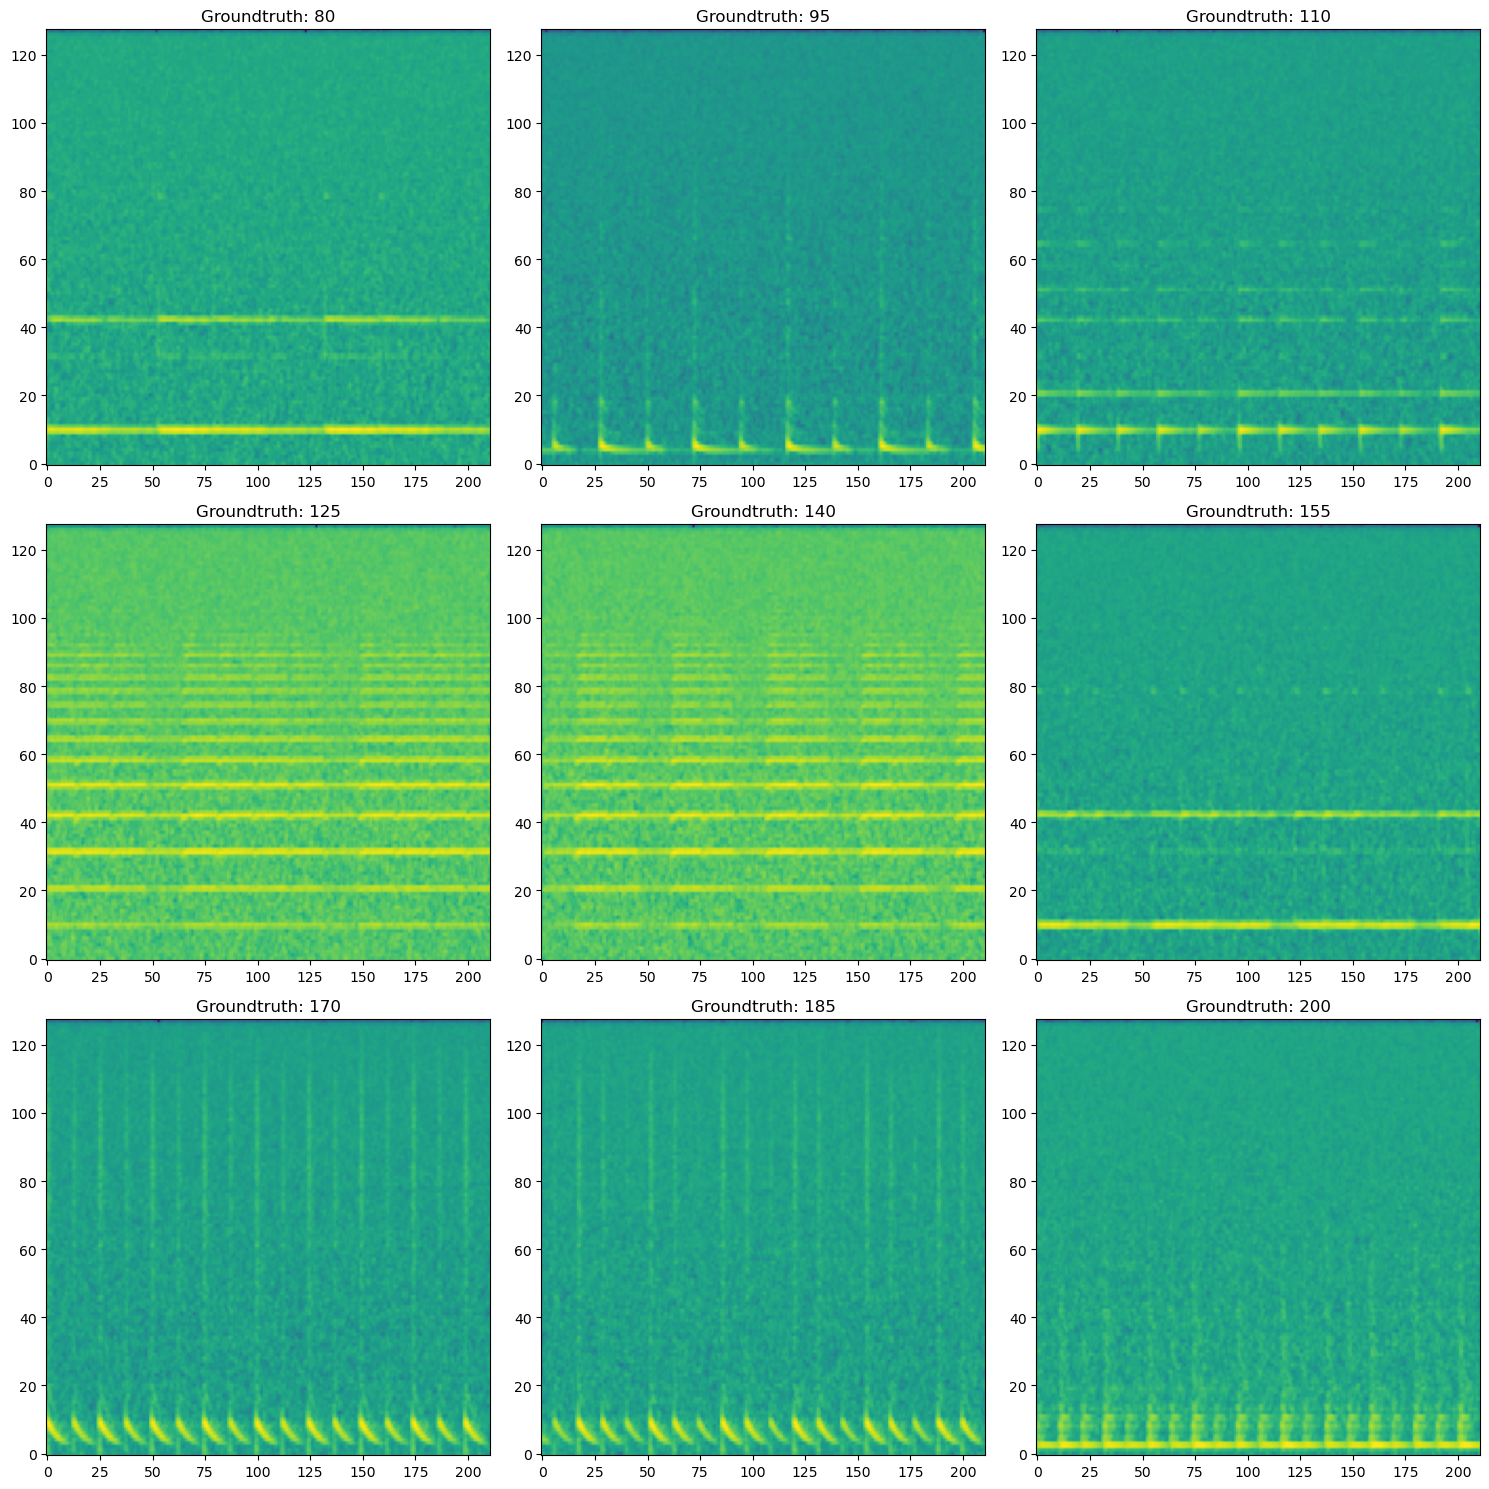

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

# Desired ground truth values
gt_values = np.linspace(ground_truth_min, ground_truth_max, 9).astype(int)

def find_indices(groundtruths, gt_values):
    indices = []
    for value in gt_values:
        idx = (torch.abs(groundtruths - value)).argmin().item()  # Find the index with the closest ground truth value
        indices.append(idx)
    return indices

# Load the entire dataset to find the indices (assuming groundtruths are not shuffled every epoch)
all_groundtruths = torch.cat([item[1] for item in DataLoader(filtered_dataset, batch_size=len(filtered_dataset))])
indices = find_indices(all_groundtruths, gt_values)

# Function to plot a single mel spectrogram
def plot_mel(mel):
    plt.imshow(librosa.power_to_db(mel.squeeze(0), ref=np.max), origin='lower', aspect='auto')
    #plt.colorbar(format='%+2.0f dB')

# Fetch and plot the mel spectrograms
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, idx in enumerate(indices):
    mel, groundtruth, librosa_bpm = filtered_dataset[idx]
    ax = axs[i // 3, i % 3]
    plt.sca(ax)  # Set the current Axes instance to ax
    plot_mel(mel)
    ax.set_title(f'Groundtruth: {groundtruth.item()}')

plt.tight_layout()
plt.show()

In [35]:
# feature extraction model

import torch
import torch.nn as nn
import torch.nn.functional as F

class SpectralFluxLayer(nn.Module):
    def forward(self, x):
        # Compute the spectral flux
        spec_flux = torch.abs(x[:, :, 1:] - x[:, :, :-1])
        return spec_flux
    
class OnsetStrengthLayer(nn.Module):
    def forward(self, x):
        # x is assumed to be the output of the SpectralFluxLayer,
        # with dimensions (batch_size, 1, num_frequencies, num_frames)
        
        # Compute a simple onset strength by summing the absolute differences
        # across the frequency dimension.
        onset_strength = torch.sum(torch.abs(x), dim=2, keepdim=True)
        
        # Apply a simple moving average filter to smooth the onset strength signal
        kernel_size = (1, 3)  # Adjust as needed
        padding_size = (0, kernel_size[1] // 2)
        onset_strength_smooth = F.avg_pool2d(onset_strength, kernel_size, padding=padding_size, stride=1)
        
        return onset_strength_smooth

class AutocorrelationLayer(nn.Module):
    def forward(self, x):
        # Ensure input is in the form (batch, channel, frequency, time)
        B, C, freq, T = x.size()  # Changed F to freq
        
        # Detrend the data by removing the mean
        x_mean = x.mean(dim=-1, keepdim=True)
        x_std = x.std(dim=-1, keepdim=True) + 1e-8  # Adding a small constant to avoid division by zero
        x_normalized = (x - x_mean) / x_std
        
        # Apply a window function (e.g., Hanning window)
        window = torch.hann_window(x_normalized.size(-1), periodic=False, device=x.device, dtype=x.dtype).view(1, 1, 1, -1)
        x_windowed = x_normalized * window
        
        x_padded = F.pad(x_windowed, (T-1, 0))
        result = F.conv2d(x_padded, x_windowed.flip(-1))
        
        print(result.shape)
        return result

def compute_input_size(H_in, W_in, out_channels_last_conv):
    # Assuming padding=1, kernel_size=3, stride=1 for Conv layers, and kernel_size=2 for MaxPool layers
    H_out = ((H_in + 2*1 - 3) // 1 + 1) // 2
    W_out = ((W_in + 2*1 - 3) // 1 + 1) // 2
    H_out = ((H_out + 2*1 - 3) // 1 + 1) // 2
    W_out = ((W_out + 2*1 - 3) // 1 + 1) // 2
    input_size = out_channels_last_conv * H_out * W_out
    return input_size

out_channels_last_conv = 64  # Assuming the last convolutional layer has 64 output channels
H, W = input_shape
inputsize = compute_input_size(H, W, out_channels_last_conv)
print(f"inputsize: {inputsize}")

class TempoEstimationNetwork(nn.Module):
    def __init__(self, num_classes):
        super(TempoEstimationNetwork, self).__init__()

        self.preprocess = nn.Sequential(
            SpectralFluxLayer(),
            OnsetStrengthLayer(),
            AutocorrelationLayer()
        )
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(inputsize, 128),  # Adjust the input size accordingly
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.preprocess(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Instantiate the network
num_classes = ground_truth_max-ground_truth_min+1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = TempoEstimationNetwork(num_classes).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

epoch_losses = []
validation_losses = []
training_mses = []
training_accuracies = []

# Additional code for optimizer, loss function, training loop, etc., as needed


inputsize: 106496


torch.Size([128, 128, 1, 211])


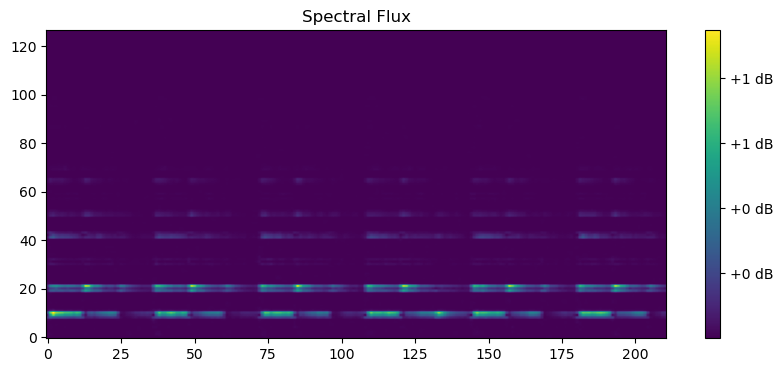

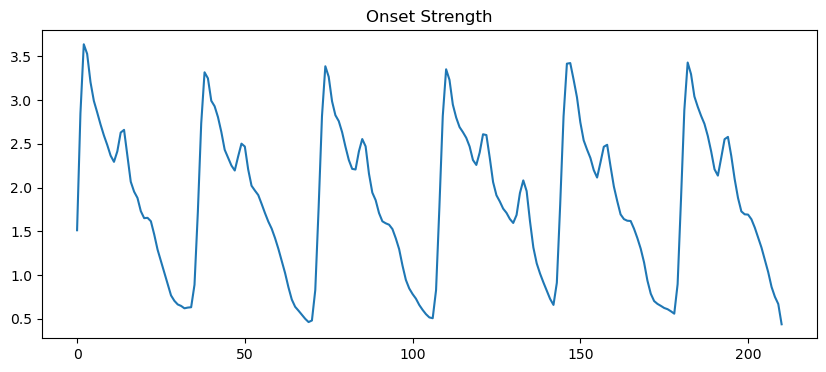

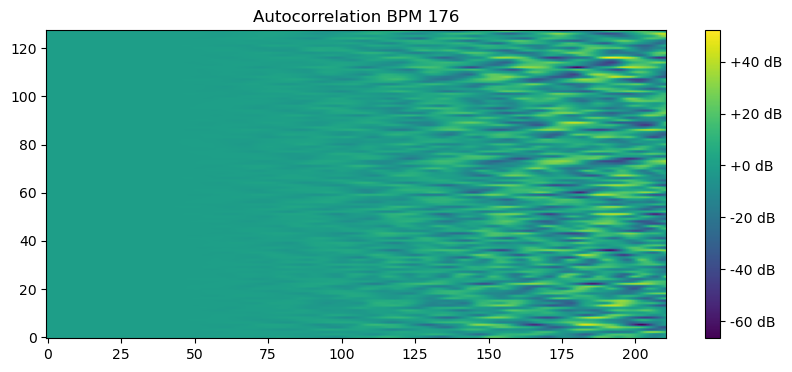

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Assume train_loader is your DataLoader object
# Also, ensure your TempoEstimationNetwork model is instantiated as `model`

# Get one batch of data
for mel_spectrograms, labels, _ in train_loader:
    break  # we only need one batch

# Ensure your data is on the right device (e.g., CPU or GPU)
mel_spectrograms = mel_spectrograms.to(device)

# Now, we'll need to get the outputs from the preprocessing layers of your model.
# For this, you may want to modify your model to return these intermediate outputs.
# For now, let's just create instances of the SpectralFluxLayer and AutocorrelationLayer.

spectral_flux_layer = SpectralFluxLayer().to(device)
onset_strength_layer = OnsetStrengthLayer().to(device)
autocorrelation_layer = AutocorrelationLayer().to(device)

# Pass the batch of Mel spectrograms through the layers
spectral_flux = spectral_flux_layer(mel_spectrograms)
onset_strength = onset_strength_layer(spectral_flux)
autocorrelation = autocorrelation_layer(onset_strength)

# Let's visualize the features for the first item in the batch.
# Convert the results to numpy for visualization.

rand_idx = np.random.randint(0, mel_spectrograms.size(0))  # Select a random index from the batch
mel = mel_spectrograms[rand_idx].squeeze().detach().cpu().numpy()
spectral_flux_np = spectral_flux[rand_idx].squeeze().detach().cpu().numpy()
autocorrelation_np = autocorrelation[rand_idx].squeeze().detach().cpu().numpy()
onset_strength_np = onset_strength[rand_idx].squeeze().detach().cpu().numpy()
gt = labels[rand_idx].detach().cpu().numpy()

# Plot the spectral flux
plt.figure(figsize=(10, 4))
plt.imshow(spectral_flux_np, aspect='auto', origin='lower', cmap='viridis')
plt.title('Spectral Flux')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Plot the onset strength
plt.figure(figsize=(10, 4))
plt.plot(onset_strength_np)  # Onset strength is a 1D signal so use plot instead of imshow
plt.title('Onset Strength')
plt.show()

# Plot the autocorrelation
plt.figure(figsize=(10, 4))
plt.imshow(autocorrelation_np, aspect='auto', origin='lower', cmap='viridis')
plt.title(f'Autocorrelation BPM {gt}')
plt.colorbar(format='%+2.0f dB')
plt.show()


In [ ]:
# train loop
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def check_early_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False
    
early_stopping = EarlyStopping(patience=8)

epochs = 120



num_batches = len(train_loader)
#torch.set_num_threads(1)


start_time = time.time()
start_time_all = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    epoch_loss = 0
    correct = 0  # Correctly predicted labels
    total = 0    # Total number of labels
    model.train()
    for batch_idx, (data, target, _) in enumerate(train_loader):
        target_zero_indexed = target - ground_truth_min  # Zero-indexing the labels here
        optimizer.zero_grad()
        batch_size, time_steps, channels, height, width = data.unsqueeze(1).size()
        data = data.view(batch_size, time_steps, channels, height, width)
        data = data.squeeze(1)
        print(data.shape) 
        outputs, _ = model(data)
        loss = criterion(outputs, target_zero_indexed)  # use zero-indexed target here
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        # Calculating accuracy
        _, predicted = torch.max(outputs.data, 1)  # get the index of the max log-probability
        total += target_zero_indexed.size(0)
        correct += predicted.eq(target_zero_indexed.data).sum().item()

        print(f"Epoch {epoch + 1}/{epochs}, batch {batch_idx+1}/{num_batches} loss: {loss.item():.6f}", end='\r')
        
    epoch_duration = time.time() - epoch_start_time
    estimated_total_time = epoch_duration * epochs
    remaining_time = (epochs - (epoch + 1)) * epoch_duration
    
    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    
    accuracy = 100 * correct / total  # compute accuracy
    training_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {mean_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, took {epoch_duration:.2f} seconds")
    print(f"Estimated Total Time: {estimated_total_time/60.0:.2f} mins, Remaining Time: {remaining_time/60.0:.2f} mins")
    
    if early_stopping.check_early_stop(mean_epoch_loss):
        print("Early stopping triggered")
        break
    
end_time = time.time() - start_time_all
print(f"{epochs} epochs took {end_time/60.0:.2f} mins")


common groundtruths: [(tensor(162), 1)]


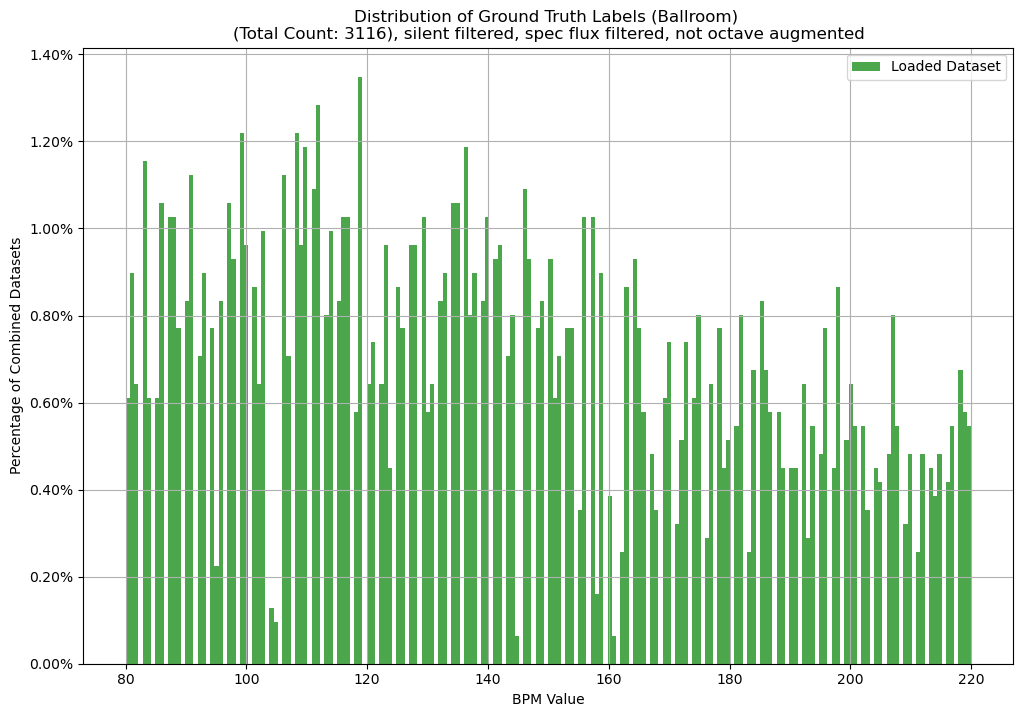

max ground truth: 220
min ground truth: 80


In [96]:
# Filtering the dataset for groundtruth between 80 and 220

# determine the most common groundtruths
from collections import Counter
groundtruth_values = [item[1] for item in filtered_dataset]
groundtruth_counts = Counter(groundtruth_values)
common_groundtruths = groundtruth_counts.most_common(1)
print(f"common groundtruths: {common_groundtruths}")

# reduce the dataset by a factor x of the most common groundtruths
reduction_factor = 0.5  # Adjust this factor as needed

# Reducing the dataset
reduced_dataset = []
for item in filtered_dataset:
    groundtruth = item[1].item()
    if groundtruth in [gt[0] for gt in common_groundtruths]:
        if np.random.rand() < reduction_factor:
            reduced_dataset.append(item)
    else:
        reduced_dataset.append(item)


# make new filtered_loader with the reduced dataset
# Creating a new DataLoader with the reduced dataset
filtered_loader = DataLoader(reduced_dataset, batch_size=batch_size, shuffle=True)

train_len = int(train_data_ratio * len(filtered_loader.dataset))  # 80% for training
val_len = len(filtered_loader.dataset) - train_len  # 20% for validation

train_dataset, val_dataset = random_split(filtered_loader.dataset, [train_len, val_len])

batch_size_new = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_new, shuffle=True)
input_shape = train_dataset[0][0].squeeze(0).shape


ground_truths = [item[1] for item in filtered_loader.dataset]

# Convert the list of ground truths to a numpy array for easy min/max computation
ground_truths_array = np.array(ground_truths)


total_samples = len(ground_truths_array)

weights = np.ones_like(ground_truths_array) / total_samples

filtered_dataset = reduced_dataset


plt.figure(figsize=(12, 8))

# Plotting the histograms stacked
plt.hist([ground_truths_array], bins=200, color=['green'], 
         alpha=0.7, label=['Loaded Dataset'], weights=[weights], stacked=True)

plt.xlabel('BPM Value')
plt.ylabel('Percentage of Combined Datasets')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
plt.title(f'Distribution of Ground Truth Labels (Ballroom) \n(Total Count: {total_samples}), silent filtered, spec flux filtered, not octave augmented')
plt.legend()
plt.grid(True)
plt.show()
print(f"max ground truth: {np.max(ground_truths_array)}")
print(f"min ground truth: {np.min(ground_truths_array)}")

In [7]:
# Get ground truth labels and bpm_librosa directly from the datasets
all_groundtruth_giant = [item[1].item() for item in train_set_giant] + [item[1].item() for item in val_set_giant]
all_groundtruth_ball = [item[1].item() for item in train_set_ball] + [item[1].item() for item in val_set_ball]
all_groundtruth_syn = [item[1].item() for item in train_set_syn] + [item[1].item() for item in val_set_syn]

all_librosa_bpm_giant = [item[2].item() for item in train_set_giant] + [item[2].item() for item in val_set_giant]
all_librosa_bpm_ball = [item[2].item() for item in train_set_ball] + [item[2].item() for item in val_set_ball]
all_librosa_bpm_syn = [item[2].item() for item in train_set_syn] + [item[2].item() for item in val_set_syn]


# Convert lists to numpy arrays
all_groundtruth_giant = np.array(all_groundtruth_giant)
all_groundtruth_ball = np.array(all_groundtruth_ball)
all_groundtruth_syn = np.array(all_groundtruth_syn)

total_samples = len(all_groundtruth_giant) + len(all_groundtruth_ball) + len(all_groundtruth_syn)

weights_giant = np.ones_like(all_groundtruth_giant) / total_samples
weights_ball = np.ones_like(all_groundtruth_ball) / total_samples
weights_syn = np.ones_like(all_groundtruth_syn) / total_samples


plt.figure(figsize=(10, 6))

# Plotting the histograms stacked
plt.hist([all_groundtruth_giant, all_groundtruth_ball, all_groundtruth_syn], bins=100, color=['blue', 'green', 'red'], 
         alpha=0.7, label=['Giant Dataset', 'Ballroom Dataset', 'synthetic Dataset'], weights=[weights_giant, weights_ball, weights_syn], stacked=True)

plt.xlabel('BPM Value')
plt.ylabel('Percentage of Combined Datasets')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
plt.title(f'Distribution of Ground Truth Labels (Ballroom+Giantsteps) \n(Total Count: {total_samples}), silent filtered, spec flux filtered, not octave augmented')
plt.legend()
plt.grid(True)
plt.show()



NameError: name 'train_set_giant' is not defined

In [27]:
# Get ground truth labels and bpm_librosa directly from the datasets

# Identify the most frequent BPM label from both datasets combined
combined_groundtruth = np.concatenate([all_groundtruth_giant, all_groundtruth_ball])
most_frequent_bpm = np.bincount(combined_groundtruth).argmax()

# Find indices of the most frequent BPM label in each dataset
indices_to_remove_giant = np.where(all_groundtruth_giant == most_frequent_bpm)[0]
indices_to_remove_ball = np.where(all_groundtruth_ball == most_frequent_bpm)[0]

# Select 50% of those indices randomly
remove_count_giant = int(len(indices_to_remove_giant) * 0.5)
remove_count_ball = int(len(indices_to_remove_ball) * 0.5)

remove_indices_giant = np.random.choice(indices_to_remove_giant, remove_count_giant, replace=False)
remove_indices_ball = np.random.choice(indices_to_remove_ball, remove_count_ball, replace=False)

# Remove the selected samples from each dataset
train_set_giant = [item for idx, item in enumerate(train_set_giant) if idx not in remove_indices_giant]
train_set_ball = [item for idx, item in enumerate(train_set_ball) if idx not in remove_indices_ball]

# Recreate DataLoaders with the modified datasets
train_loader = DataLoader(train_set_giant + train_set_ball, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set_giant + val_set_ball, batch_size=batch_size, shuffle=True)

# ... (Rest of the code remains the same)

In [21]:
# class BPMEstimator(nn.Module):
#     def __init__(self, input_shape):
#         super(BPMEstimator, self).__init__()

#         self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=(1, 1))
#         self.bn1 = nn.BatchNorm2d(32)
        
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=(1, 1))
#         self.bn2 = nn.BatchNorm2d(64)
        
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=(1, 1))
#         self.bn3 = nn.BatchNorm2d(128)

#         # Compute the size after conv and pooling layers
#         self.fc1_input_size, self.h_after_conv = self.compute_flattened_size(input_shape)
        
#         self.lstm = nn.LSTM(input_size=self.h_after_conv * 128, hidden_size=64, batch_first=True)

#         self.fc1 = nn.Linear(64, 128)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(128, 1)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.max_pool2d(x, (2, 2))

#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.max_pool2d(x, (2, 2))

#         x = F.relu(self.bn3(self.conv3(x)))
#         x = F.max_pool2d(x, (2, 2))

#         # Prepare data for LSTM
#         batch_size, channels, height, width = x.size()
#         x = x.view(batch_size, width, -1)  # Flatten only the height and channels

#         # Pass data through LSTM
#         x, _ = self.lstm(x)

#         # Only use the last LSTM output (many-to-one RNN structure)
#         x = x[:, -1, :]

#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
        
#         return x

#     def compute_flattened_size(self, input_shape):
#         dummy_tensor = torch.ones(1, 1, *input_shape)  
#         x = self.conv1(dummy_tensor)
#         x = F.max_pool2d(x, 2)
#         x = self.conv2(x)
#         x = F.max_pool2d(x, 2)
#         x = self.conv3(x)
#         x = F.max_pool2d(x, 2)
#         _, c, h, w = x.shape
#         return c * h, h


class BPMEstimator(nn.Module):
    def __init__(self, input_shape):
        super(BPMEstimator, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Compute the size after conv and pooling layers to be fed into LSTM
        _, c, h, w = self.compute_intermediate_size(input_shape)
        self.lstm_size = h * c  # new lstm_size
        self.lstm = nn.LSTM(input_size=self.lstm_size, hidden_size=64, batch_first=True)
        
        self.fc1 = nn.Linear(64, 128)  # LSTM hidden size to 128
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        # Reshape data for LSTM
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, width, height * channels)  # Reshaped here
        
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the last output of LSTM
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

    def compute_intermediate_size(self, input_shape):
        dummy_tensor = torch.ones(1, 1, *input_shape)
        x = self.conv1(dummy_tensor)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        return x.shape



def weighted_cross_entropy(output, target, amplify_factor=1.0):
    ce = nn.CrossEntropyLoss(reduction='none')(output, target)  
    
    # Get predicted class indices
    _, preds = torch.max(output, 1)
    
    # Compute absolute difference between predicted and true classes
    diffs = torch.abs(preds - target).float()
    
    # Normalize differences to get a penalty between 0 and 1, then amplify if desired
    max_possible_diff = float(num_classes - 1)  # the maximum possible difference
    penalties = (diffs / max_possible_diff) * amplify_factor
    
    # Apply penalties to the cross entropy loss values
    weighted_loss = ce * penalties
    
    return weighted_loss.mean()




model = BPMEstimator(input_shape)
print(input_shape)

num_classes = ground_truth_max-ground_truth_min+1

weights_matrix = torch.zeros(num_classes, num_classes)

for i in range(num_classes):
    for j in range(num_classes):
        weights_matrix[i, j] = abs((i + ground_truth_min) - (j + ground_truth_min))

# Normalize weights to be between 0 and 1
weights_matrix = 1 - (weights_matrix / weights_matrix.max())


# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
# criterion = weighted_cross_entropy
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)
epoch_losses = []
validation_losses = []
training_mses = []
training_accuracies = []

torch.Size([128, 211])


In [4]:
## 2 channel SNN

class SpikingNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(SpikingNet, self).__init__()

        self.surr_grad = surrogate.FastSigmoid.apply

        # First convolutional layer
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=2)
        self.lif1 = snn.Leaky(beta=0.2)

        # Pooling
        self.pool = nn.AvgPool2d(2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.lif2 = snn.Leaky(beta=0.2)

        # Fully connected layer
        self.fc1_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        self.fc1 = nn.Linear(self.fc1_size, 1000)
        self.lif3 = snn.Leaky(beta=0.2)

        # Output layer
        self.fc2 = nn.Linear(1000, num_classes)

    def forward(self, x, mem=None):
        if mem is None:
            mem = {
                'conv1': torch.zeros(x.size(0), 32, x.size(2), x.size(3), device=x.device),
                'conv2': torch.zeros(x.size(0), 64, x.size(2)//2, x.size(3)//2, device=x.device),
                'fc1': torch.zeros(x.size(0), 1000, device=x.device)
            }

        # First convolutional layer
        x, mem['conv1'] = self.lif1(self.conv1(x), mem['conv1'])
        x = self.surr_grad(x)
        x = self.pool(x)

        # Second convolutional layer
        x, mem['conv2'] = self.lif2(self.conv2(x), mem['conv2'])
        x = self.surr_grad(x)
        x = self.pool(x)

        # Flatten for the fully connected layer
        x = x.view(-1, self.fc1_size)

        # Fully connected layer
        x, mem['fc1'] = self.lif3(self.fc1(x), mem['fc1'])
        x = self.surr_grad(x)

        # Output layer
        x = self.fc2(x)
        
        return x, mem

# Define your SNN model
print(num_classes)

def weighted_cross_entropy(output, target, amplify_factor=1.0):
    ce = nn.CrossEntropyLoss(reduction='none')(output, target)  
    
    # Get predicted class indices
    _, preds = torch.max(output, 1)
    
    # Compute absolute difference between predicted and true classes
    diffs = torch.abs(preds - target).float()
    
    # Normalize differences to get a penalty between 0 and 1, then amplify if desired
    max_possible_diff = float(num_classes - 1)  # the maximum possible difference
    penalties = (diffs / max_possible_diff) * amplify_factor
    
    # Apply penalties to the cross entropy loss values
    weighted_loss = ce * penalties
    
    return weighted_loss.mean()




num_classes = ground_truth_max-ground_truth_min+1


# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
#criterion = weighted_cross_entropy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikingNet(input_shape, num_classes).to(device)

# Define loss function and optimizer
#criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)



121


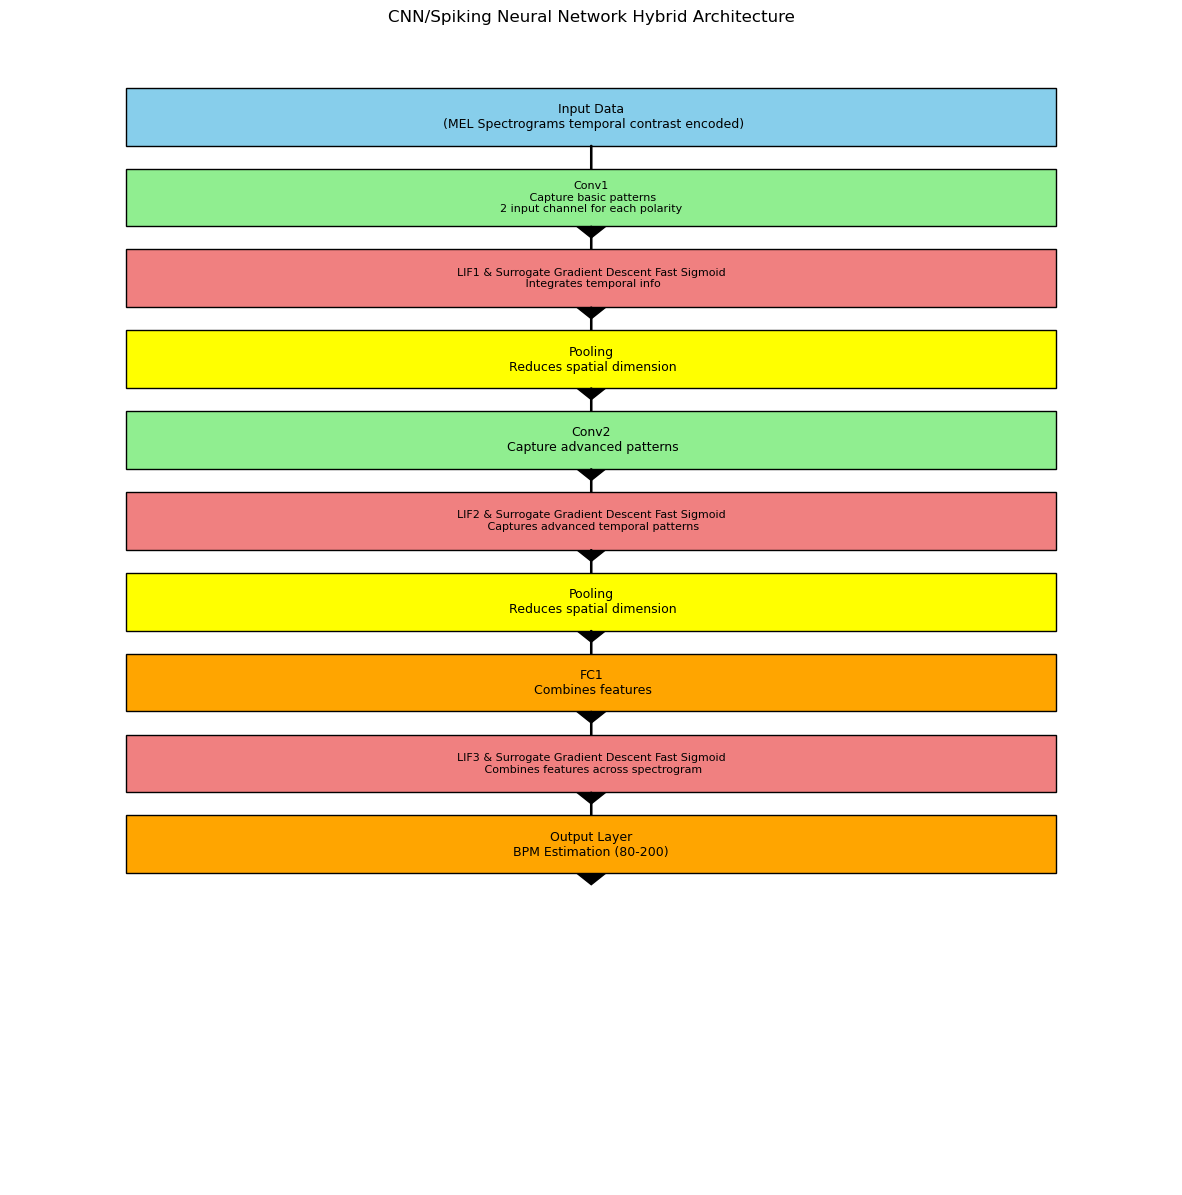

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_snn_architecture():
    fig, ax = plt.subplots(figsize=(15, 15))
    
    def draw_arrow(x, y, height=0.06):
        ax.arrow(x, y, 0, -height, head_width=0.05, head_length=0.02, fc='k', ec='k')
    
    # Input Data
    ax.add_patch(patches.Rectangle((0.1, 0.9), 0.8, 0.05, facecolor='skyblue', edgecolor="black"))
    ax.text(0.5, 0.925, f'Input Data\n (MEL Spectrograms temporal contrast encoded)', ha='center', va='center' , fontsize=9)
    draw_arrow(0.5, 0.9)

    # Conv1
    ax.add_patch(patches.Rectangle((0.1, 0.83), 0.8, 0.05, facecolor='lightgreen', edgecolor="black"))
    ax.text(0.5, 0.855, f'Conv1\n Capture basic patterns\n2 input channel for each polarity', ha='center', va='center' , fontsize=8)
    draw_arrow(0.5, 0.83)

    # LIF1 & Surrogate Gradient
    ax.add_patch(patches.Rectangle((0.1, 0.76), 0.8, 0.05, facecolor='lightcoral', edgecolor="black"))
    ax.text(0.5, 0.785, f'LIF1 & Surrogate Gradient Descent Fast Sigmoid\n Integrates temporal info', ha='center', va='center' , fontsize=8)
    draw_arrow(0.5, 0.76)

    # Pooling
    ax.add_patch(patches.Rectangle((0.1, 0.69), 0.8, 0.05, facecolor='yellow', edgecolor="black"))
    ax.text(0.5, 0.715, f'Pooling\n Reduces spatial dimension', ha='center', va='center' , fontsize=9)
    draw_arrow(0.5, 0.69)

    # Conv2
    ax.add_patch(patches.Rectangle((0.1, 0.62), 0.8, 0.05, facecolor='lightgreen', edgecolor="black"))
    ax.text(0.5, 0.645, f'Conv2\n Capture advanced patterns', ha='center', va='center' , fontsize=9)
    draw_arrow(0.5, 0.62)

    # LIF2 & Surrogate Gradient
    ax.add_patch(patches.Rectangle((0.1, 0.55), 0.8, 0.05, facecolor='lightcoral', edgecolor="black"))
    ax.text(0.5, 0.575, f'LIF2 & Surrogate Gradient Descent Fast Sigmoid\n Captures advanced temporal patterns', va='center' , ha='center', fontsize=8)
    draw_arrow(0.5, 0.55)

    # Pooling
    ax.add_patch(patches.Rectangle((0.1, 0.48), 0.8, 0.05, facecolor='yellow', edgecolor="black"))
    ax.text(0.5, 0.505, f'Pooling\n Reduces spatial dimension', va='center' , ha='center', fontsize=9)
    draw_arrow(0.5, 0.48)

    # Fully Connected 1
    ax.add_patch(patches.Rectangle((0.1, 0.41), 0.8, 0.05, facecolor='orange', edgecolor="black"))
    ax.text(0.5, 0.435, f'FC1\n Combines features', ha='center', va='center' , fontsize=9)
    draw_arrow(0.5, 0.41)

    # LIF3 & Surrogate Gradient
    ax.add_patch(patches.Rectangle((0.1, 0.34), 0.8, 0.05, facecolor='lightcoral', edgecolor="black"))
    ax.text(0.5, 0.365, f'LIF3 & Surrogate Gradient Descent Fast Sigmoid\n Combines features across spectrogram', va='center' , ha='center', fontsize=8)
    draw_arrow(0.5, 0.34)

    # Fully Connected 2 (Output Layer)
    ax.add_patch(patches.Rectangle((0.1, 0.27), 0.8, 0.05, facecolor='orange', edgecolor="black"))
    ax.text(0.5, 0.295, 'Output Layer\nBPM Estimation (80-200)', ha='center', va='center' , fontsize=9)


    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.title("CNN/Spiking Neural Network Hybrid Architecture")
    
    plt.show()

plot_snn_architecture()


In [43]:
# # Training parameters
# num_epochs = 10
# time_steps = 3

# for epoch in range(num_epochs):
#     model.train()

#     for i, (inputs, labels, _) in enumerate(train_loader):
#         inputs, labels = inputs.to(device), labels.to(device)
#         target_zero_indexed = labels - ground_truth_min  # Zero-indexing the labels here

#         # Reset gradients
#         optimizer.zero_grad()

#         mem = None
#         for step in range(time_steps):
#             outputs, mem = model(inputs, mem)
        
#         loss = criterion(outputs, target_zero_indexed)
#         loss.backward()
#         optimizer.step()

#         # Print every 100 batches
#         print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(train_loader)}], Loss: {loss.item():.4f}", end='\r')

#criterion = nn.CrossEntropyLoss()
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def check_early_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

early_stopping = EarlyStopping(patience=8)
train_loader = DataLoader(train_loader.dataset, batch_size=200, shuffle=True, drop_last=True)
num_batches = len(train_loader)

start_time_all = time.time()

num_epochs = 5
time_steps = 3

epoch_losses = []
training_accuracies = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    epoch_loss = 0
    correct = 0
    total = 0
    model.train()

    for i, (inputs, labels, _) in enumerate(train_loader):
        batch_start_time = time.time()
        
        inputs, labels = inputs.to(device), labels.to(device)
        target_zero_indexed = labels - ground_truth_min

        optimizer.zero_grad()

        mem = None
        for step in range(time_steps):
            outputs, mem = model(inputs, mem)
        
        loss = criterion(outputs, target_zero_indexed)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += target_zero_indexed.size(0)
        correct += predicted.eq(target_zero_indexed.data).sum().item()

        batch_duration = time.time() - batch_start_time
        estimated_remaining_time = batch_duration * (num_batches - (i + 1))
        
        # Display the current loss and estimated remaining time for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{num_batches}, Loss: {loss.item():.4f}, Est. Remaining Time: {estimated_remaining_time:.2f} secs", end='\r')
        
    epoch_duration = time.time() - epoch_start_time
    estimated_total_time = epoch_duration * num_epochs
    remaining_time = (num_epochs - (epoch + 1)) * epoch_duration
    
    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    
    accuracy = 100 * correct / total
    training_accuracies.append(accuracy)
    print(f"\nEpoch {epoch + 1}/{num_epochs}, Training Loss: {mean_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, took {epoch_duration:.2f} seconds")
    print(f"Estimated Total Time: {estimated_total_time/60.0:.2f} mins, Remaining Time: {remaining_time/60.0:.2f} mins")
    
    beepy.beep(sound=1)  # 1 for 'coin'    
    if early_stopping.check_early_stop(mean_epoch_loss):
        print("Early stopping triggered")
        break
    
end_time = time.time() - start_time_all
print(f"{num_epochs} epochs took {end_time/60.0:.2f} mins")


Epoch 1/5, Batch 52/52, Loss: 0.0281, Est. Remaining Time: 0.00 secsss
Epoch 1/5, Training Loss: 0.0159, Accuracy: 99.88%, took 1228.43 seconds
Estimated Total Time: 102.37 mins, Remaining Time: 81.90 mins


KeyboardInterrupt: 

In [7]:
# Set the model to evaluation mode
model.eval()

# Keep track of the total loss
total_loss = 0.0
total_corrects = 0

# No need to compute gradients during validation
with torch.no_grad():
    for i, (inputs, labels, _) in enumerate(val_loader):  # Assuming you have a val_loader for validation data
        inputs, labels = inputs.to(device), labels.to(device)
        target_zero_indexed = labels - ground_truth_min

        mem = None
        for step in range(time_steps):
            outputs, mem = model(inputs, mem)

        loss = criterion(outputs, target_zero_indexed)
        total_loss += loss.item()

        # Assuming this is a classification task and you want to calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_corrects += (predicted == target_zero_indexed).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = total_corrects / len(val_loader.dataset)

    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Validation Loss: 0.1648, Accuracy: 0.9721


In [3]:
# SCNN
# import snntorch as snn
# from snntorch import surrogate
# from snntorch import functional as SF
# from snntorch import utils

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

# Set the number of OpenMP threads used by PyTorch
torch.set_num_threads(os.cpu_count())
#torch.set_num_threads(1)

def compute_input_size(H_in, W_in):
    # Assuming padding=1, kernel_size=3, stride=1 for Conv layers, and kernel_size=2 for MaxPool layers
    H_out = ((H_in + 2*1 - 3) // 1 + 1) // 2
    W_out = ((W_in + 2*1 - 3) // 1 + 1) // 2
    H_out = ((H_out + 2*1 - 3) // 1 + 1) // 2
    W_out = ((W_out + 2*1 - 3) // 1 + 1) // 2
    input_size = 64 * H_out * W_out
    return input_size


H, W = input_shape
inputsize = compute_input_size(H, W)
num_classes = ground_truth_max-ground_truth_min+1
print(inputsize)
class SpikingBPMEstimator(nn.Module):
    def __init__(self, inputsize):
        super(SpikingBPMEstimator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),  # Batch Normalization after Conv2d layer
            nn.ReLU(),
            nn.MaxPool2d(2),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Batch Normalization after Conv2d layer
            nn.ReLU(),
            nn.MaxPool2d(2),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
            nn.Flatten(),
           # nn.Dropout(0.5),  # Dropout layer with 50% dropout rate
            nn.Linear(inputsize, 128),
            nn.ReLU(),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
            nn.Linear(128, num_classes),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
        )

    def forward(self, x):
        utils.reset(self.net)  # resets hidden states for all LIF neurons in net
        
        return self.net(x)
    

# Assuming input_shape_syn is defined somewhere in your code:
model = SpikingBPMEstimator(inputsize=inputsize).to(device)

# # Training setup
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)
# #loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)  # Or use nn.MSELoss() or any other loss function
# criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

epoch_losses = []
validation_losses = []
training_mses = []
training_accuracies = []

106496


In [9]:
# paper snn

import torch
import torch.nn as nn
from spikingjelly.activation_based import layer
from spikingjelly.activation_based import surrogate, neuron
import modules

# class SHD_STSC(nn.Module):
#     def __init__(self):
#         super().__init__()

#         time_rf_conv = 5
#         time_rf_at = 3

#         self.fc = nn.Sequential(
#             modules.STSC(700,dimension=2,time_rf_conv=time_rf_conv, time_rf_at=time_rf_at, use_gate=True, use_filter=True),
#             layer.Linear(700,128),
#             neuron.LIFNode(tau=10.0, decay_input=False, v_threshold=0.3, surrogate_function=surrogate.ATan(), detach_reset=True),
#             # modules.STSC(128,dimension=2,time_rf_conv=time_rf_conv, time_rf_at=time_rf_at, use_gate=True, use_filter=True),
#             layer.Linear(128,128),
#             neuron.LIFNode(tau=10.0, decay_input=False, v_threshold=0.3, surrogate_function=surrogate.ATan(), detach_reset=True),
#             # modules.STSC(128,dimension=2,time_rf_conv=time_rf_conv, time_rf_at=time_rf_at, use_gate=True, use_filter=True),
#             layer.Linear(128,100),
#             neuron.LIFNode(tau=10.0, decay_input=False, v_threshold=0.3, surrogate_function=surrogate.ATan(), detach_reset=True),
#             layer.VotingLayer(5)
#         )

#     def forward(self, x: torch.Tensor):
#         return self.fc(x)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def compute_input_size(H_in, W_in):
    # Assuming padding=1, kernel_size=3, stride=1 for Conv layers, and kernel_size=2 for MaxPool layers
    H_out = ((H_in + 2*1 - 3) // 1 + 1) // 2
    W_out = ((W_in + 2*1 - 3) // 1 + 1) // 2
    H_out = ((H_out + 2*1 - 3) // 1 + 1) // 2
    W_out = ((W_out + 2*1 - 3) // 1 + 1) // 2
    input_size = 64 * H_out * W_out
    return input_size

class AdaptedSHD_STSC(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AdaptedSHD_STSC, self).__init__()

        time_rf_conv = 5
        time_rf_at = 3

        # Adjust the input dimensions of the first STSC layer
        self.fc = nn.Sequential(
            modules.STSC(input_size, dimension=2, time_rf_conv=time_rf_conv, time_rf_at=time_rf_at, use_gate=True, use_filter=True),
            layer.Linear(input_size, 128),  # Adjusted to match your input size
            neuron.LIFNode(tau=10.0, decay_input=False, v_threshold=0.3, surrogate_function=surrogate.ATan(), detach_reset=True),
            layer.Linear(128, 128),
            neuron.LIFNode(tau=10.0, decay_input=False, v_threshold=0.3, surrogate_function=surrogate.ATan(), detach_reset=True),
            layer.Linear(128, num_classes),  # Adjusted to match your number of classes
            neuron.LIFNode(tau=10.0, decay_input=False, v_threshold=0.3, surrogate_function=surrogate.ATan(), detach_reset=True),
            layer.VotingLayer(num_classes)  # Adjusted to match your number of classes
        )

    def forward(self, x: torch.Tensor):
        return self.fc(x)

# Assuming input_shape is defined somewhere
H, W = input_shape
input_size = compute_input_size(H, W)  # Using your compute_input_size function
num_classes = ground_truth_max - ground_truth_min + 1  # Assuming these variables are defined

model = AdaptedSHD_STSC(input_size=input_size, num_classes=num_classes).to(device)


    

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 136096776192 bytes. Error code 12 (Cannot allocate memory)

In [27]:

class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def check_early_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False
    
early_stopping = EarlyStopping(patience=8)

epochs = 30
# torch.set_num_threads(os.cpu_count()-1)
#train_loader = DataLoader(train_loader.dataset, batch_size=256, shuffle=True, drop_last=True)
num_batches = len(train_loader)
start_time = time.time()
start_time_all = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    epoch_loss = 0
    correct = 0  # Correctly predicted labels
    total = 0    # Total number of labels
    model.train()
    for batch_idx, (data, target, _) in enumerate(train_loader):
        target_zero_indexed = target - ground_truth_min  # Zero-indexing the labels here
        optimizer.zero_grad()


        # batch_size, time_steps, channels, height, width = data.unsqueeze(1).unsqueeze(1).size()
        batch_size, time_steps, channels, height, width = data.unsqueeze(1).size()
        data = data.view(batch_size, time_steps, channels, height, width)
        data = data.squeeze(1)
        outputs = model(data.float())
        loss = criterion(outputs, target_zero_indexed)  # use zero-indexed target here
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        
        # Calculating accuracy
        _, predicted = torch.max(outputs.data, 1)  # get the index of the max log-probability
        total += target_zero_indexed.size(0)
        correct += predicted.eq(target_zero_indexed.data).sum().item()

        print(f"Epoch {epoch + 1}/{epochs}, batch {batch_idx+1}/{num_batches} loss: {loss.item():.6f}", end='\r')


        
    epoch_duration = time.time() - epoch_start_time
    estimated_total_time = epoch_duration * epochs
    remaining_time = (epochs - (epoch + 1)) * epoch_duration
    
    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    
    accuracy = 100 * correct / total  # compute accuracy
    training_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {mean_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, took {epoch_duration:.2f} seconds")
    print(f"Estimated Total Time: {estimated_total_time/60.0:.2f} mins, Remaining Time: {remaining_time/60.0:.2f} mins")
    beepy.beep(sound=1)  # 1 for 'coin'
    if early_stopping.check_early_stop(mean_epoch_loss):
        print("Early stopping triggered")
        break
    
end_time = time.time() - start_time_all
print(f"{epochs} epochs took {end_time/60.0:.2f} mins")


Epoch 1/30, Training Loss: 1.0537, Accuracy: 70.02%, took 132.56 seconds
Estimated Total Time: 66.28 mins, Remaining Time: 64.07 mins
Epoch 2/30, Training Loss: 0.9660, Accuracy: 72.20%, took 132.63 seconds
Estimated Total Time: 66.32 mins, Remaining Time: 61.90 mins
Epoch 3/30, Training Loss: 0.8939, Accuracy: 74.60%, took 133.20 seconds
Estimated Total Time: 66.60 mins, Remaining Time: 59.94 mins
Epoch 4/30, Training Loss: 0.8228, Accuracy: 76.45%, took 132.30 seconds
Estimated Total Time: 66.15 mins, Remaining Time: 57.33 mins
Epoch 5/30, Training Loss: 0.7505, Accuracy: 78.65%, took 128.69 seconds
Estimated Total Time: 64.34 mins, Remaining Time: 53.62 mins
Epoch 6/30, Training Loss: 0.7030, Accuracy: 80.04%, took 126.19 seconds
Estimated Total Time: 63.10 mins, Remaining Time: 50.48 mins
Epoch 7/30, Training Loss: 0.6319, Accuracy: 81.93%, took 125.89 seconds
Estimated Total Time: 62.95 mins, Remaining Time: 48.26 mins
Epoch 8/30, Training Loss: 0.5843, Accuracy: 83.74%, took 126.

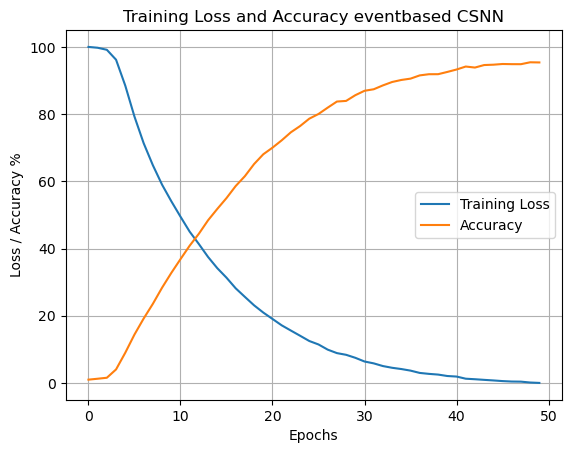

In [30]:
def min_max_normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

norm1 = min_max_normalize(np.array(epoch_losses))* 100

# If the accuracy is between 0 and 1, multiply by 100. 
# If it's already in the range 0-100, you don't need to multiply.
norm2 = np.array(training_accuracies)  # Adjust as per your data

plt.plot(norm1, label="Training Loss")
plt.plot(norm2, label="Accuracy")
plt.grid(True)
plt.title("Training Loss and Accuracy eventbased CSNN")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy %")
plt.legend()
plt.show()

In [6]:
# load the model
model_load_path = "SCNN_SYNDATA_E6_BPM200_ACC_99.pth"
model = SpikingNet(input_shape, num_classes)
model.load_state_dict(torch.load(model_load_path))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt
import time

epochs = 60

train_loader = DataLoader(train_set_syn, batch_size=256, shuffle=True, drop_last=True)

def octave_loss(outputs, target):
    half_outputs = outputs / 2
    double_outputs = outputs * 2

    loss_original = torch.abs(target - outputs)
    loss_half = torch.abs(target - half_outputs)
    loss_double = torch.abs(target - double_outputs)

    min_loss = torch.min(loss_original, torch.min(loss_half, loss_double))

    return torch.mean(min_loss)

# train_dataset = train_loader.dataset
# val_dataset = val_loader.dataset

# new_batch_size = 512  # or whatever value you want

# train_loader = DataLoader(train_dataset, batch_size=new_batch_size, shuffle=True, drop_last=False)
# val_loader = DataLoader(val_dataset, batch_size=new_batch_size, shuffle=False, drop_last=False)


start_time = time.time()
start_time_all = time.time()
for epoch in range(epochs):
    epoch_loss = 0
    training_mse = 0    
    model.train()
    for data, target, _ in train_loader:
        optimizer.zero_grad()
        print(data.shape)
        outputs = model(data).squeeze()  # Squeeze out the redundant dimension
        loss = criterion(outputs, target.float())
        # loss = octave_loss(outputs, target.float())  # Use the custom loss function
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    mean_epoch_loss = epoch_loss / len(train_loader)
    
    epoch_losses.append(mean_epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {mean_epoch_loss:.4f}, took {time.time() - start_time:.2f} seconds")
    start_time = time.time()

    
    # # Calculate validation loss
    # model.eval()
    # with torch.no_grad():
    #     val_loss = 0
    #     for data, target in test_loader:
    #         outputs = model(data).squeeze()
    #         loss = criterion(outputs, target.float())
    #         val_loss += loss.item()
    #     mean_val_loss = val_loss / len(test_loader)
    #     validation_losses.append(mean_val_loss)

    # print(f"Epoch {epoch+1}/{epochs}, Training Loss: {mean_epoch_loss:.4f} took {time.time() - start_time:.2f} seconds")
endtime = time.time() - start_time_all
print(f"{epochs} epochs took {endtime/60.0} mins")

# Plot the loss over epochs
plt.plot(epoch_losses, label="Training Loss")
# plt.plot(training_mses, label="Training MSE")
# plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


torch.Size([256, 1, 98, 188])


ValueError: too many values to unpack (expected 2)

In [44]:
# Save the model
# model_save_path = f"CSNN_SYNDATA_{epoch}_BPM200_ACC_{training_accuracies[-1]:.0f}.pth"
# CSNN_SYNDATA_20_BPM200_ACC_39.pth
# Model saved to CNN_SYNDATA_E5_BPM140_ACC_99.pth
# SCNN_SYNDATA_E8_BPM200_ACC_99.pth
model_save_path = f"SCNN_SYNDATA_E{epoch}_BPM200_ACC_99.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to SCNN_SYNDATA_E1_BPM200_ACC_99.pth


In [8]:
# load the model
# model_load_path = "BPMEstimator_giantstep_big_octave.pth"
model_load_path = "CSNN_SYNDATA_20_BPM200_ACC_39.pth"
model = SpikingBPMEstimator(input_shape)
model.load_state_dict(torch.load(model_load_path))

TypeError: empty(): argument 'size' must be tuple of ints, but found element of type torch.Size at pos 2

In [ ]:
# single step cnn

import torch
import torch.nn as nn
import torch.nn.functional as F

class MFModule(nn.Module):
    """ Multi-filter module """
    def __init__(self):
        super(MFModule, self).__init__()
        
        self.avg_pool = nn.AvgPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0))  # Adjust kernel size based on requirements
        self.batch_norm = nn.BatchNorm2d(16)
        
        # Parallel convolutional layers
        # self.conv_layers = nn.ModuleList([
        #     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 32)),
        #     nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1, 64)),
        #     nn.Conv2d(in_channels=16, out_channels=96, kernel_size=(1, 96)),
        #     nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(1, 128)),
        #     # nn.Conv2d(in_channels=16, out_channels=192, kernel_size=(1, 192)),
        #     # nn.Conv2d(in_channels=16, out_channels=256, kernel_size=(1, 256))
        # ])
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 32), stride=1, padding=(0, 15)),  # padding = (kernel_size - 1) / 2
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1, 16), stride=1, padding=(0, 7)),   # padding = (kernel_size - 1) / 2
            nn.Conv2d(in_channels=16, out_channels=96, kernel_size=(1, 8), stride=1, padding=(0, 3)),    # padding = (kernel_size - 1) / 2
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(1, 4), stride=1, padding=(0, 1)),   # padding = (kernel_size - 1) / 2
        ])

        self.bottleneck = nn.Conv2d(in_channels=320, out_channels=16, kernel_size=(1, 1))
        
    def forward(self, x):
        x = self.avg_pool(x)
        x = self.batch_norm(x)
        
        conv_outs = [F.elu(conv(x)) for conv in self.conv_layers]
        x = torch.cat(conv_outs, dim=1)
        
        x = self.bottleneck(x)
        return x


class TemporalCNN(nn.Module):
    def __init__(self):
        super(TemporalCNN, self).__init__()
        
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 5), padding=(0, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 5), padding=(0, 2))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 5), padding=(0, 2))
        
        # Multi-filter modules
        self.mf_mods = nn.ModuleList([MFModule() for _ in range(4)])
        
        # Fully connected layers
        self.fc1 = nn.Linear(258048, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 256)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        
        for mf_mod in self.mf_mods:
            x = mf_mod(x)
        
        # Flattening the tensor before feeding to fully connected layers
        x = torch.flatten(x, 1)
        
        x = self.dropout(F.elu(self.fc1(x)))
        x = F.elu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

model = TemporalCNN()
print(model)

# Loss and optimizer
criterion_2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# If GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20  # Adjust as needed

for epoch in range(num_epochs):
    for batch_idx, (data, targets, _, _) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(data).squeeze()
        loss = criterion_2(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


In [ ]:
# second training
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    correct = 0
    total = 0
    for data, targets, _  in val_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data).squeeze()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Accuracy on test data: {100 * correct / total:.2f}%")

TypeError: to() received an invalid combination of arguments - got (CurrentDeviceProxy), but expected one of:
 * (torch.device device, torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (Tensor tensor, bool non_blocking, bool copy, *, torch.memory_format memory_format)


In [5]:
# snn
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from snntorch import spikegen

import torch
import torch.nn as nn
from torchvision import datasets, transforms

dtype = torch.float32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


spike_grad = surrogate.fast_sigmoid(slope=25)

class SpikingBPMEstimator(nn.Module):
    def __init__(self, input_shape, beta=0.95, num_steps=50):
        super(SpikingBPMEstimator, self).__init__()
        
        # Define the Conv Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        # Compute the size after conv and pooling layers
        dummy_tensor = torch.ones(1, 1, *input_shape)
        x = self.conv1(dummy_tensor)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        _, c, h, w = x.shape
        self.fc1_input_size = c * h * w

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        self.fc2 = nn.Linear(128, num_classes)
        self.lif4 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        self.num_steps = num_steps

    def forward(self, x):
        orig_x = x  # Store the initial input
        # Initialize the hidden states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        # Record the spikes
        spk4_rec = []

        for step in range(self.num_steps):
            # Conv Layer 1
            x = self.conv1(orig_x)  # Use the stored tensor here
            spk1, mem1 = self.lif1(x, mem1)
            x = F.max_pool2d(spk1, 2)

            # Conv Layer 2
            x = self.conv2(x)
            spk2, mem2 = self.lif2(x, mem2)
            x = F.max_pool2d(spk2, 2)
            
            # Flatten and Pass through FC Layers
            x = x.view(x.size(0), -1)
            
            x = self.fc1(x)
            spk3, mem3 = self.lif3(x, mem3)
            
            x = self.fc2(spk3)
            spk4, mem4 = self.lif4(x, mem4)
            
            spk4_rec.append(spk4)

        return torch.stack(spk4_rec, dim=0)

print(input_shape)
model = SpikingBPMEstimator(input_shape).to(device)

# Define a loss function and an optimizer
loss_fn = nn.MSELoss()  # or any other appropriate loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# data, targets, bpm_lib = next(iter(train_loader))
# data = data.to(device)
# targets = targets.to(device)

# spk_rec, mem_rec = spiking_model(data)

# # 50 time steps, 10 samples of data, 4 output neurons
# print(mem_rec.size())



torch.Size([100, 211])


In [45]:
def correct_octave_error(predictions, true_values):
        # If the inputs are not iterable (lists or arrays), wrap them in a list.
    corrected_predictions = []
        
    for pred, true in zip(predictions, true_values):
        half_pred = pred / 2
        double_pred = pred * 2
        
        error_original = abs(true - pred)
        error_half = abs(true - half_pred)
        error_double = abs(true - double_pred)
        
        if error_half < error_original:
            corrected_predictions.append(half_pred)
        elif error_double < error_original:
            corrected_predictions.append(double_pred)
        else:
            corrected_predictions.append(pred)
            
    return np.array(corrected_predictions)

def is_SNN(model):
    for name, module in model.named_modules():
        if isinstance(module, snn.Leaky):
            return True
    return False

model_type = 'SCNN' if is_SNN(model) else "CNN"


# model.eval()
# data, targets, librosa_bpm = next(iter(train_loader))
# # outputs, _ = model(data)
# outputs = model(data)
# predictions = torch.argmax(outputs, dim=1) + ground_truth_min
# #predictions = outputs

# fig, axarr = plt.subplots(3, 3, figsize=(15, 15))  # create a 3x3 grid of plots

# for i in range(3):
#     for j in range(3):
#         idx = i * 3 + j  # get the current index in the batch
        
#         # plot mel spectrogram
#         mel_data = data[idx].squeeze(0)
#         axarr[i, j].imshow(librosa.power_to_db(mel_data, ref=np.max), origin='lower', aspect='auto')
#         #corrected_pred = correct_octave_error([int(predictions[idx])], [int(targets[idx])])
#         axarr[i, j].set_title(f"Librosa BPM: {int(librosa_bpm[idx])} Pred: {int(predictions[idx])},  True: {int(targets[idx])}")
#         axarr[i, j].axis('off')  # hide axis

# plt.tight_layout()
# plt.show()


# No need to compute gradients during validation
# with torch.no_grad():
#     for i, (inputs, labels, _) in enumerate(val_loader):  # Assuming you have a val_loader for validation data
#         inputs, labels = inputs.to(device), labels.to(device)
#         target_zero_indexed = labels - ground_truth_min

#         mem = None
#         for step in range(time_steps):
#             outputs, mem = model(inputs, mem)

#         loss = criterion(outputs, target_zero_indexed)
#         total_loss += loss.item()

#         # Assuming this is a classification task and you want to calculate accuracy
#         _, predicted = torch.max(outputs, 1)
#         total_corrects += (predicted == target_zero_indexed).sum().item()

#     avg_loss = total_loss / len(val_loader)
#     accuracy = total_corrects / len(val_loader.dataset)

#     print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    


# Set model to evaluation mode
model.eval()

all_predictions = []
all_confidences = []
all_true_labels = []
librosa_bpm_estimates = []  # List to store Librosa's BPM estimates

#val_syn_loader = DataLoader(val_set_syn, batch_size=128, shuffle=True, drop_last=False)

# # No gradient is needed during evaluation/inference
# cnt = 0
# #val_loader = DataLoader(transformed_val_dataset, batch_size=128, shuffle=True) # bigger batch size causes kernel crash
# with torch.no_grad():
#     for data, target, librosa_bpm in val_loader:
#         # outputs, _ = model(data)
#         outputs = model(data)
#         predictions = torch.argmax(outputs, dim=1) + ground_truth_min
#         all_predictions.extend(predictions.cpu().numpy()) 
#         all_true_labels.extend(target.cpu().numpy())
#         librosa_bpm_estimates.extend(librosa_bpm.cpu().numpy())

cnt = 0 

with torch.no_grad():
    for data, target, librosa_bpm in val_loader:
        data = data.to(device)
        target_zero_indexed = target.to(device) - ground_truth_min

        mem = None
        for step in range(time_steps):
            outputs, mem = model(data, mem)

        predictions = torch.argmax(outputs, dim=1) + ground_truth_min
        confidences = torch.max(torch.softmax(outputs, dim=1), dim=1)[0].cpu().numpy()
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(target.cpu().numpy())
        all_confidences.extend(confidences)
        librosa_bpm_estimates.extend(librosa_bpm.cpu().numpy())



# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
all_confidences = np.array(all_confidences)
librosa_bpm_estimates = np.array(librosa_bpm_estimates)

# Korrigiere die Vorhersagen für das Modell und Librosa
all_predictions_corrected = correct_octave_error(all_predictions, all_true_labels)
librosa_bpm_estimates_corrected = correct_octave_error(librosa_bpm_estimates, all_true_labels)

In [46]:


def visualize_based_on_threshold(threshold=0.5, tolerance=1.0):
    # Clear previous plots
    clear_output(wait=True)
    
    # Filter based on confidence threshold
    
    high_confidence_indices = np.where(all_confidences > threshold)
    filtered_predictions = all_predictions[high_confidence_indices]
    filtered_true_labels = all_true_labels[high_confidence_indices]
    filtered_accuracy = np.mean(np.abs(filtered_true_labels - filtered_predictions) <= tolerance) * 100
    correct_predictions = np.abs(all_true_labels - all_predictions) <= tolerance
    correct_predictions_lib = np.abs(all_true_labels - librosa_bpm_estimates) <= tolerance
    accuracy = np.mean(correct_predictions) * 100  # This gives the percentage of predictions within the defined range.
    accuracy_lib = np.mean(correct_predictions_lib) * 100  # This gives the percentage of predictions within the defined range.
    print(f"Model ({model_type}) accuracy within ±{tolerance} BPM: {accuracy:.2f}%, Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%")
    print(f"cnt  {len(filtered_predictions)}/{len(all_true_labels)}")
    # Update your scatter plot or any other visualizations using high_confidence_indices
    plt.figure(figsize=(8, 8))
    plt.scatter(all_true_labels[high_confidence_indices], all_predictions[high_confidence_indices], color='red', alpha=0.3)
    plt.scatter(all_true_labels, librosa_bpm_estimates, alpha=0.3, color='green', label='Librosa Estimates')  # Plotting Librosa's BPM estimates in green
    plt.axhline(y=0, color='k', linestyle='--')
    plt.title(f"Model ({model_type}) accuracy within ±{tolerance} BPM: {filtered_accuracy:.2f}%\n Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%\n confidence threshold: {threshold}\n after {len(epoch_losses)} epochs")
    plt.xlabel('True Values')
    plt.grid(True)
    plt.legend()
    

    plt.show()
       


# Define and display slider
threshold_slider = widgets.FloatSlider(value=0.5, min=0, max=0.99, step=0.01, description='Confidence Threshold:')
tolerance_slider = widgets.IntSlider(value=1, min=1, max=30, step=1, description='Tolerance:')
widgets.interactive(visualize_based_on_threshold, threshold=threshold_slider, tolerance=tolerance_slider)


interactive(children=(FloatSlider(value=0.5, description='Confidence Threshold:', max=0.99, step=0.01), IntSli…

In [ ]:

# Calculate Mean Absolute Errors
model_mae = np.mean(np.abs(all_true_labels - all_predictions))
librosa_mae = np.mean(np.abs(all_true_labels - librosa_bpm_estimates))
model_corrected_mae = np.mean(np.abs(all_true_labels - all_predictions_corrected))

# Plot Mean Absolute Errors
model_label = f'Model ({model_type})'
labels = ['Librosa', model_label]
errors = [librosa_mae, model_mae]

plt.figure(figsize=(10, 6))
plt.bar(labels, errors, color=['red', 'green'])
plt.xlabel('Method')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Mean Absolute Errors')
plt.tight_layout()
plt.show()